In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

## Step 1: Camera calibration

Compensate distortion and other effects with the chessboard-calibration-image.
Make a list of all calibration images and calculate the camera matrix and distortion coefficients.

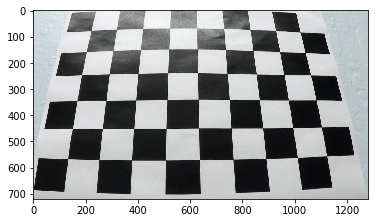

In [2]:
# Load calibration images
fnames = glob.glob('camera_cal/calibration*.jpg')

# Display a nice example calibration image
exs_img = cv2.imread(fnames[13])
plt.imshow(exs_img)

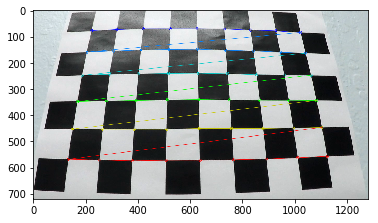

In [3]:
# Array to store object-points and image-points from the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image space

chessb_size_x = 9
chessb_size_y = 6
objp = np.zeros((chessb_size_x*chessb_size_y,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

for i, fname in enumerate(fnames):
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find corners of the Chessboard
    ret, corners = cv2.findChessboardCorners(gray, (chessb_size_x,chessb_size_y), None)

    if ret==True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw first image as example
        if i==13:
            img = cv2.drawChessboardCorners(img, (chessb_size_x,chessb_size_y), corners, ret)
            plt.imshow(img)

# Get calibration parameter
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

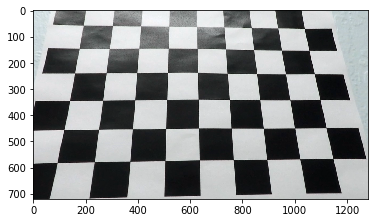

In [4]:
# Display undistorted example images
udst_img = cv2.undistort(exs_img, mtx, dist, None, mtx)
plt.imshow(udst_img)

# Step 2: Preprocessing Images

First generate a binary image based on color-threholds after HLS convertion followed by gradient-magnitude and direction thresholds.

In [5]:
def preprocess_image(img, mtx, dist):
    
    # Parameters to tweak:
    ch_thresh = (90, 255)
    sobel_kernel = 9
    mag_thresh = (30,150)
    dir_thresh = (0.5, 1.4) # between 0 and pi/2
    
    # Undistort with calibration-parameters
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert to HLS space
    hls = cv2.cvtColor(dst, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2] # get only saturation channel
    
    # Calculate gradient magnitude
    sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(S, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Calculate direction gradient
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply all thresholds and create binary output
    binary = np.zeros_like(S)
    binary[(S > ch_thresh[0]) & (S <= ch_thresh[1]) &
           ( ((gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])) |
             ((direction >= dir_thresh[0]) & (direction <= dir_thresh[1])) )] = 1
    
    return binary
    

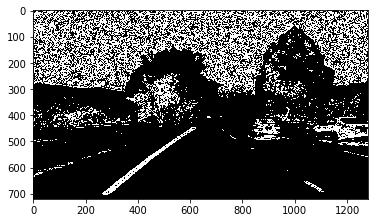

In [6]:
####### Test output
test_img = cv2.imread('test_images/test1.jpg')
#test_img = cv2.imread('test_images/straight_lines1.jpg')

test_binary = preprocess_image(test_img, mtx, dist)
plt.imshow(test_binary, cmap='gray')
#####################

# Step 3: Perspective Transform

Seccond apply a perspective transform. Lane lines are better extracted from the bird-perspective.

In [7]:
def perspective_transform(img, reverse=False):
    # Define source points. These were specified by hand from an example image with a straight road
    src = np.float32([[580,460], [700,460], [1115,720], [195,720]])
    offset = 200
    dst = np.float32([[offset,0],
                      [img.shape[1]-offset, 0],
                      [img.shape[1]-offset,img.shape[0]],
                      [offset,img.shape[0]]])
    
    if reverse:
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    
    return warped

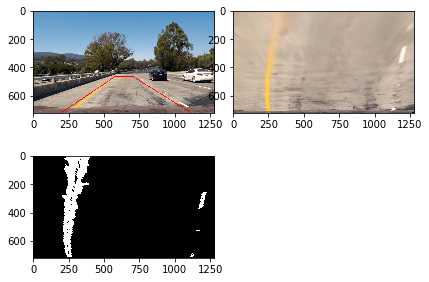

In [8]:
####### Test output
points = np.array([[580,460], [700,460], [1115,720], [195,720]])
poly = test_img.copy()
cv2.polylines(poly, np.int32([points]), 1, (0,0,255), 3)
plt.subplot(221)
plt.tight_layout()
plt.imshow(cv2.cvtColor(poly, cv2.COLOR_BGR2RGB))

warped = perspective_transform(test_img)
plt.subplot(222)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
test_binary_warped = perspective_transform(test_binary)
plt.subplot(223)
plt.imshow(test_binary_warped, cmap='gray')
######################

# Step 4: Finding Lane Pixels

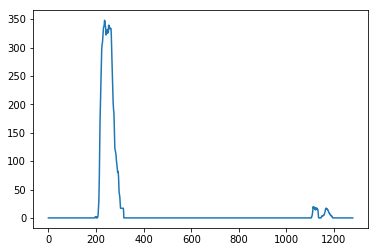

In [9]:
######## Test output
dbg_histogram = np.sum(test_binary_warped[test_binary_warped.shape[0]//2:,:], axis=0)
plt.plot(dbg_histogram)
######################

In [10]:
def find_lane_lines(binary_warped_img, gen_out_img=False):
    histogram = np.sum(test_binary_warped[binary_warped_img.shape[0]//2:,:], axis=0)
    
    if gen_out_img:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
    else:
        out_img = None
        
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped_img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped_img.shape[0] - (window+1)*window_height
        win_y_high = binary_warped_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if gen_out_img:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if gen_out_img:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, out_img

(720, 0)

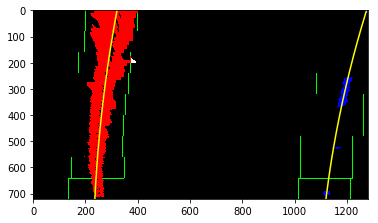

In [11]:
#### Test output
(left_fit, right_fit, out_img) = find_lane_lines(test_binary_warped, True)

# Generate x and y values for plotting
ploty = np.linspace(0, test_binary_warped.shape[0]-1, test_binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
############

In [12]:
def infer_lines_from_prev(binary_warped_img, left_fit, right_fit):
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    #plotty = np.linspace(0, binary_warped_img.shape[0]-1, binary_warped_img.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit

# Step 5: Calculate Curvature and Radius

In [20]:
def get_curv_and_radius(ploty, leftx, rightx, left_fit, right_fit):
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    return left_curverad, right_curverad

# Step 6: Draw result back onto image

In [14]:
def draw_lines_to_img(undist, warped, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective_transform(color_warp, True) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

1713.21784777 1273.091789


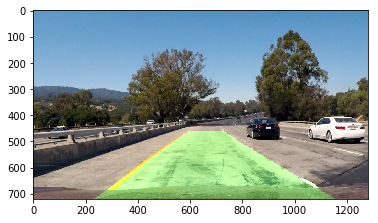

In [21]:
#### Test output

left_curv, right_curv = get_curv_and_radius(ploty, left_fitx, right_fitx, left_fit, right_fit)
print(left_curv, right_curv)
result = draw_lines_to_img(test_img, test_binary_warped, ploty, left_fitx, right_fitx)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

############